In [142]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.dpi"] = 300

## OnePass only plots

In [213]:
df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stackedl bar plot",  H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if i > 8:
                    rect.set_hatch("o" * int(i / n_col)) #edited part                         
                else:
                    rect.set_hatch("//" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 430, 30))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Number of clients")
    axe.set_ylabel("WiscSort relative slowdown (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    # l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(0.885,0.69),  prop={'size': 6})
    print(h[:n_col])
    tmp1 = h[:4]
    tmp1.append(h[6])
    tmp2 = l[:4]
    tmp2.append(l[6])
    l1 = axe.legend(tmp1, tmp2, loc='center', bbox_to_anchor=(0.2,0.81),  prop={'size': 10}, frameon = False)
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0, alpha=.99)) 
    n.append(axe.bar(0, 0, color="gray", hatch=H * 3, alpha=.99)) 
    n.append(axe.bar(0,0, color="gray", hatch="o" *2, alpha=.99)) 
    
    labels = ['Write sequential', 'Read sequential', 'Read random']
    if labels is not None:
        # l2 = plt.legend(n, labels, loc=[1.01, 0.1])
        # l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.96,0.98), prop={'size': 6})
        l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.68,0.99), prop={'size': 10}, frameon = False)
    # plt.savefig('interference-overhead.pdf', bbox_inches="tight")
    return axe

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            #print(df)
        send.append(df)
    print(send)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

[  RUN read RUN sort RUN write RUN other  MERGE read  MERGE write RECORD read  \
1  3.75496  6.67331   50.4468  0.200143         0.0          0.0     16.8888   
2  5.09646  8.64521   117.246  0.337169         0.0          0.0     18.0334   
3  6.50061  10.4542   222.373  0.764674         0.0          0.0     24.2377   
4  9.32428  12.1126   227.457   1.03866         0.0          0.0     33.1026   
5    12.36   15.975     228.8  0.553176         0.0          0.0     40.5204   
6   14.182  19.3585   251.096   1.63648         0.0          0.0     44.7265   
7  17.2917  24.0262   268.069   1.57938         0.0          0.0      55.984   
8  21.5741  29.3177   276.321   2.26262         0.0          0.0     64.8025   

   MERGE other  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
7          0.0  
8          0.0  ,   RUN read RUN sort RUN write RUN other  MERGE read  MERGE write RECORD read  \
1  2.25511  6.54336    11.295  0.190463     

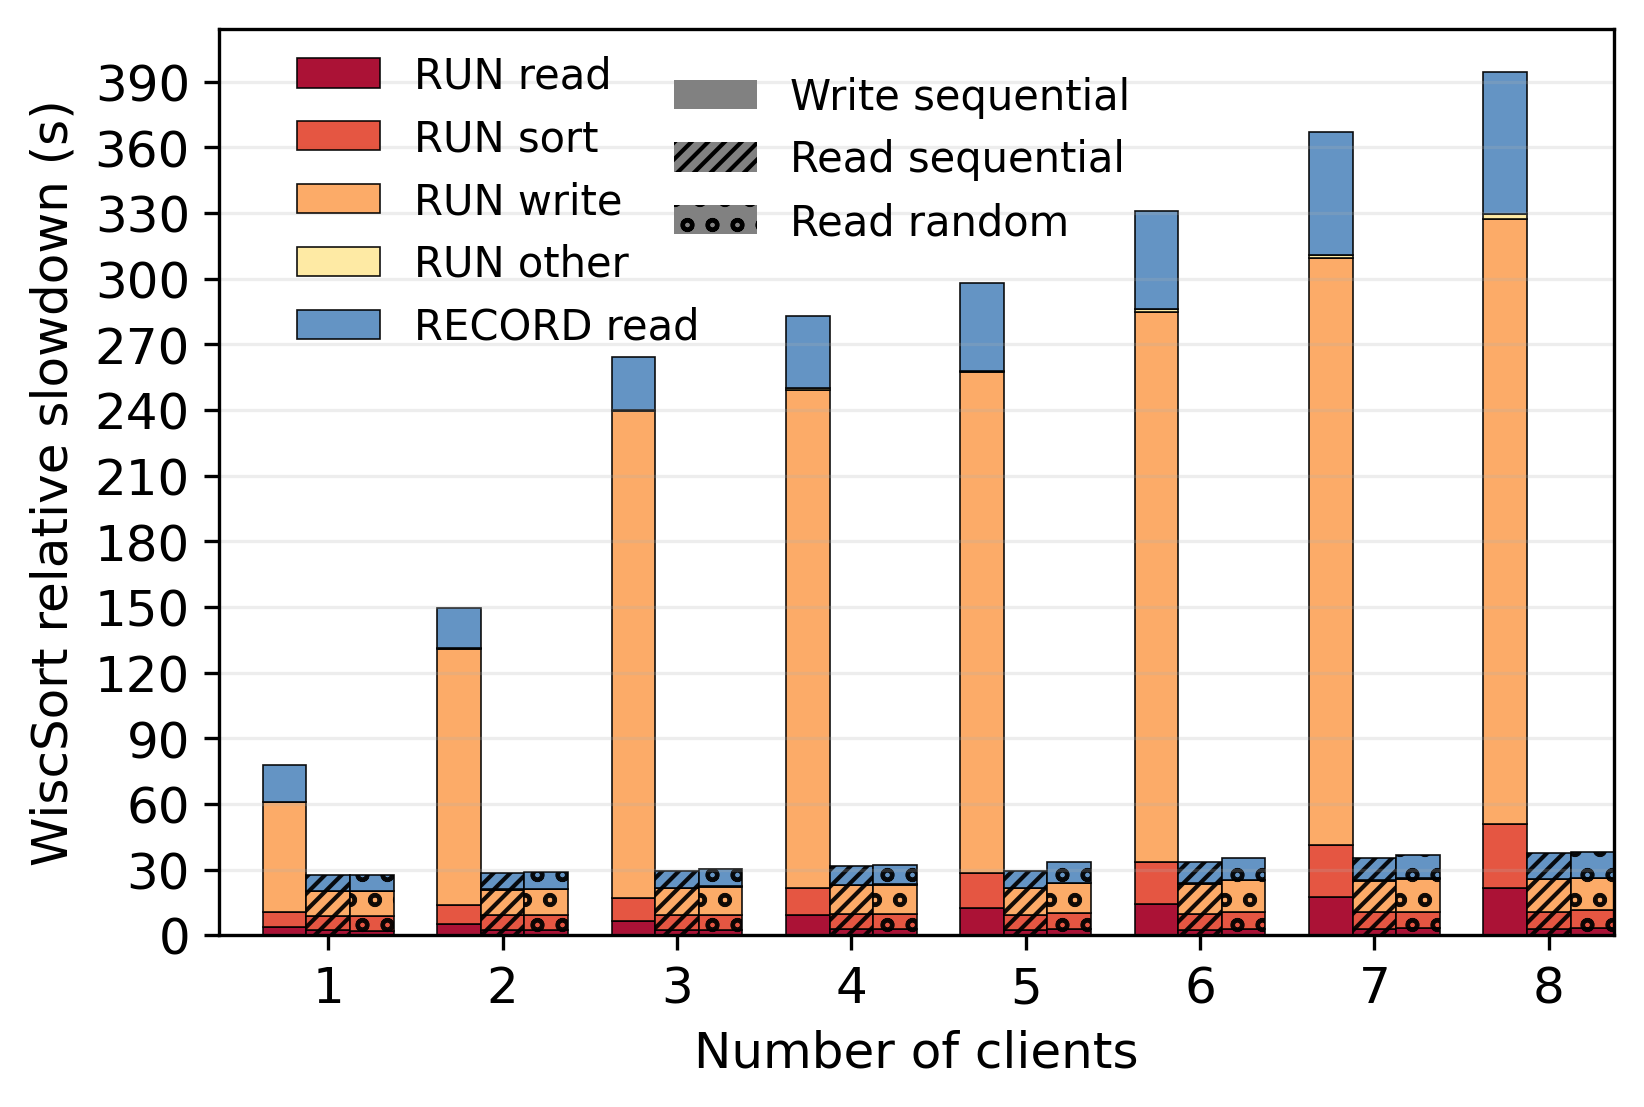

In [214]:
stacked_bar_runtime('interference/40',['1', '2', '3', '4', '5', '6', '7', '8'],['onepass_write', 'onepass_read_seq', 'onepass_read_rand'])

In [147]:
labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
pure = [2.00056,6.28685,11.2043,0.152445,0.0,0.0,6.56312,0.0]

df = pd.DataFrame()
def stacked_bar_overhead(folder,iters, exps):
    send = []
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            df = pd.concat([df, results])
            #print(df)
        send.append(df)
    res = []
    for idf in send:
        res.append(idf.sub(pure, axis='columns'))
    plot_clustered_stacked(res, exps, title="", cmap=plt.cm.RdYlBu)

[<BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>]


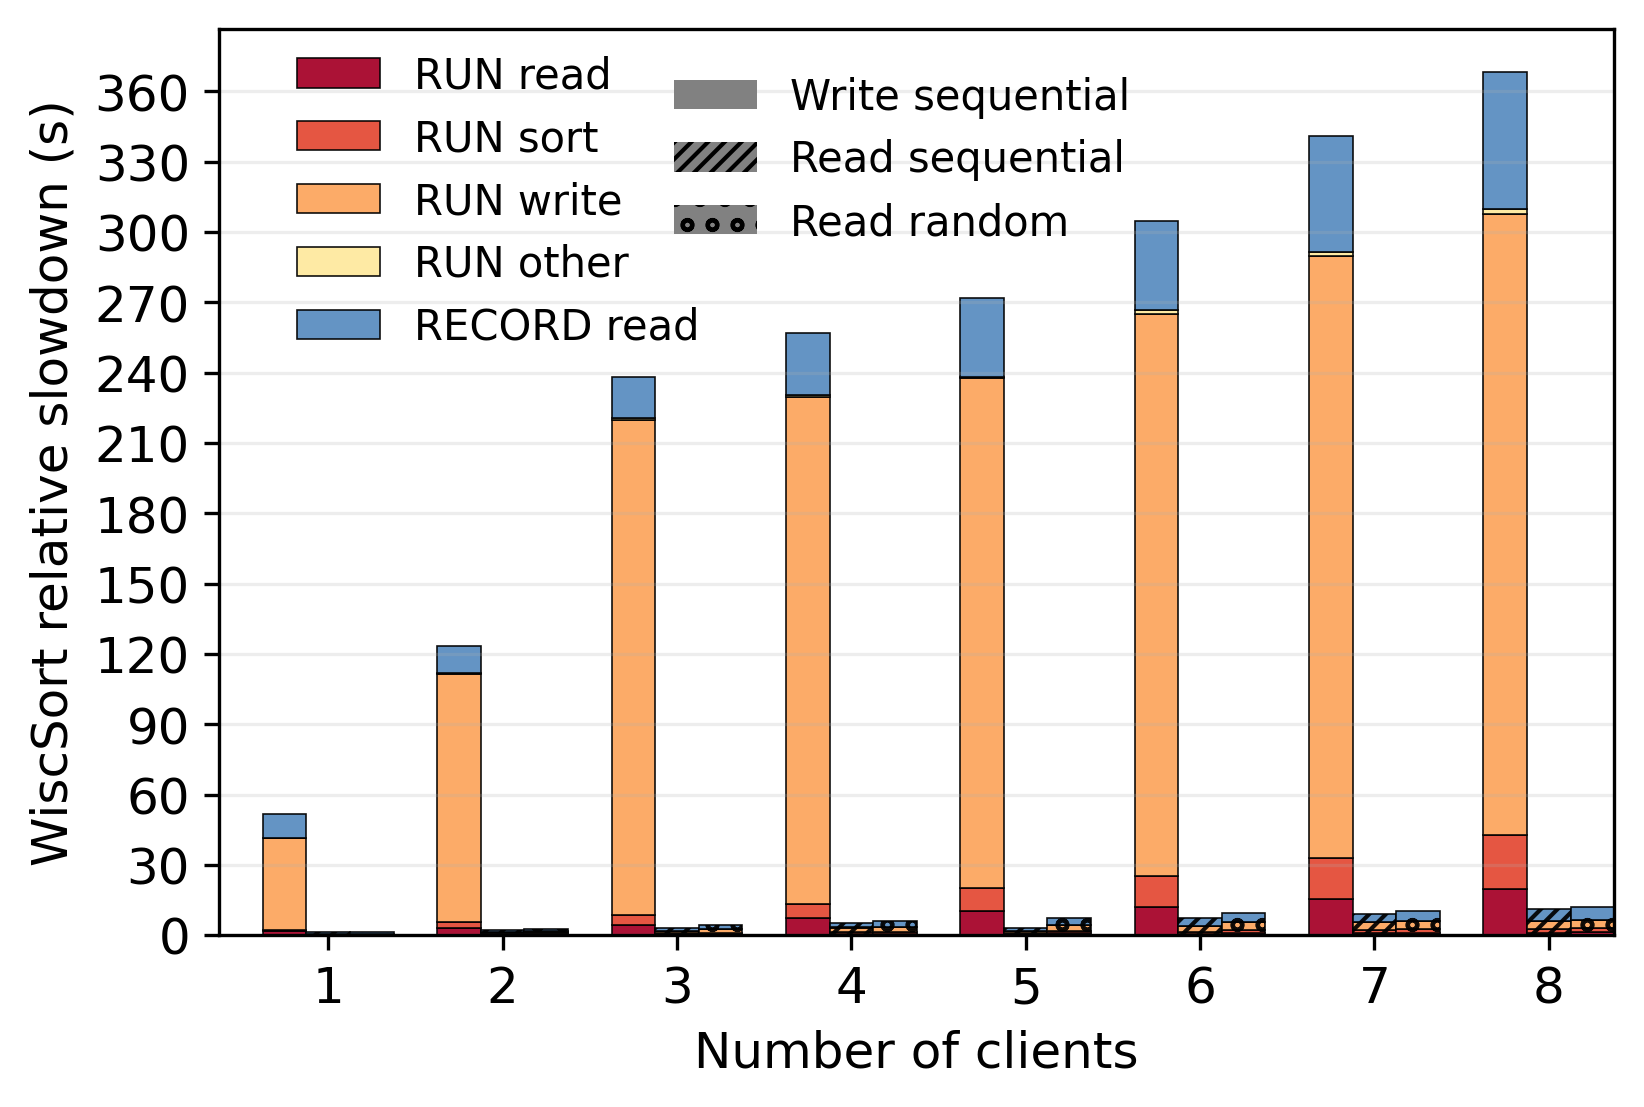

In [208]:
stacked_bar_overhead('interference/40',['1', '2', '3', '4', '5', '6', '7', '8'],['onepass_write', 'onepass_read_seq', 'onepass_read_rand'])

## EMS + OnePass plots

In [185]:
df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stackedl bar plot",  H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if i > 8:
                    rect.set_hatch("o" * int(i / n_col)) #edited part                         
                else:
                    rect.set_hatch("/" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 42, 2))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Number of reader clients")
    axe.set_ylabel("Relative slowdown (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    # l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(0.885,0.69),  prop={'size': 6})
    # l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(1.3,0.81),  prop={'size': 10}, frameon = False)
    # axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0, alpha=.99)) 
    n.append(axe.bar(0, 0, color="gray", hatch=H * 2, alpha=.99)) 
    n.append(axe.bar(0,0, color="gray", hatch="o" *1, alpha=.99)) 
    n.append(axe.bar(0,0, color="gray", hatch="o" *2, alpha=.99)) 
    
    labels = ['WiscSort w/ sequential', 'WiscSort w/ random', 'EMS w/ sequential', 'EMS w/ random']
    if labels is not None:
        # l2 = plt.legend(n, labels, loc=[1.01, 0.1])
        # l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.96,0.98), prop={'size': 6})
        l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.5,0.99), prop={'size': 10}, frameon = False)
    # plt.savefig('interference-read-overhead.pdf', bbox_inches="tight")
    return axe

In [147]:
def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            #print(df)
        send.append(df)
    # print(send)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

NameError: name 'l1' is not defined

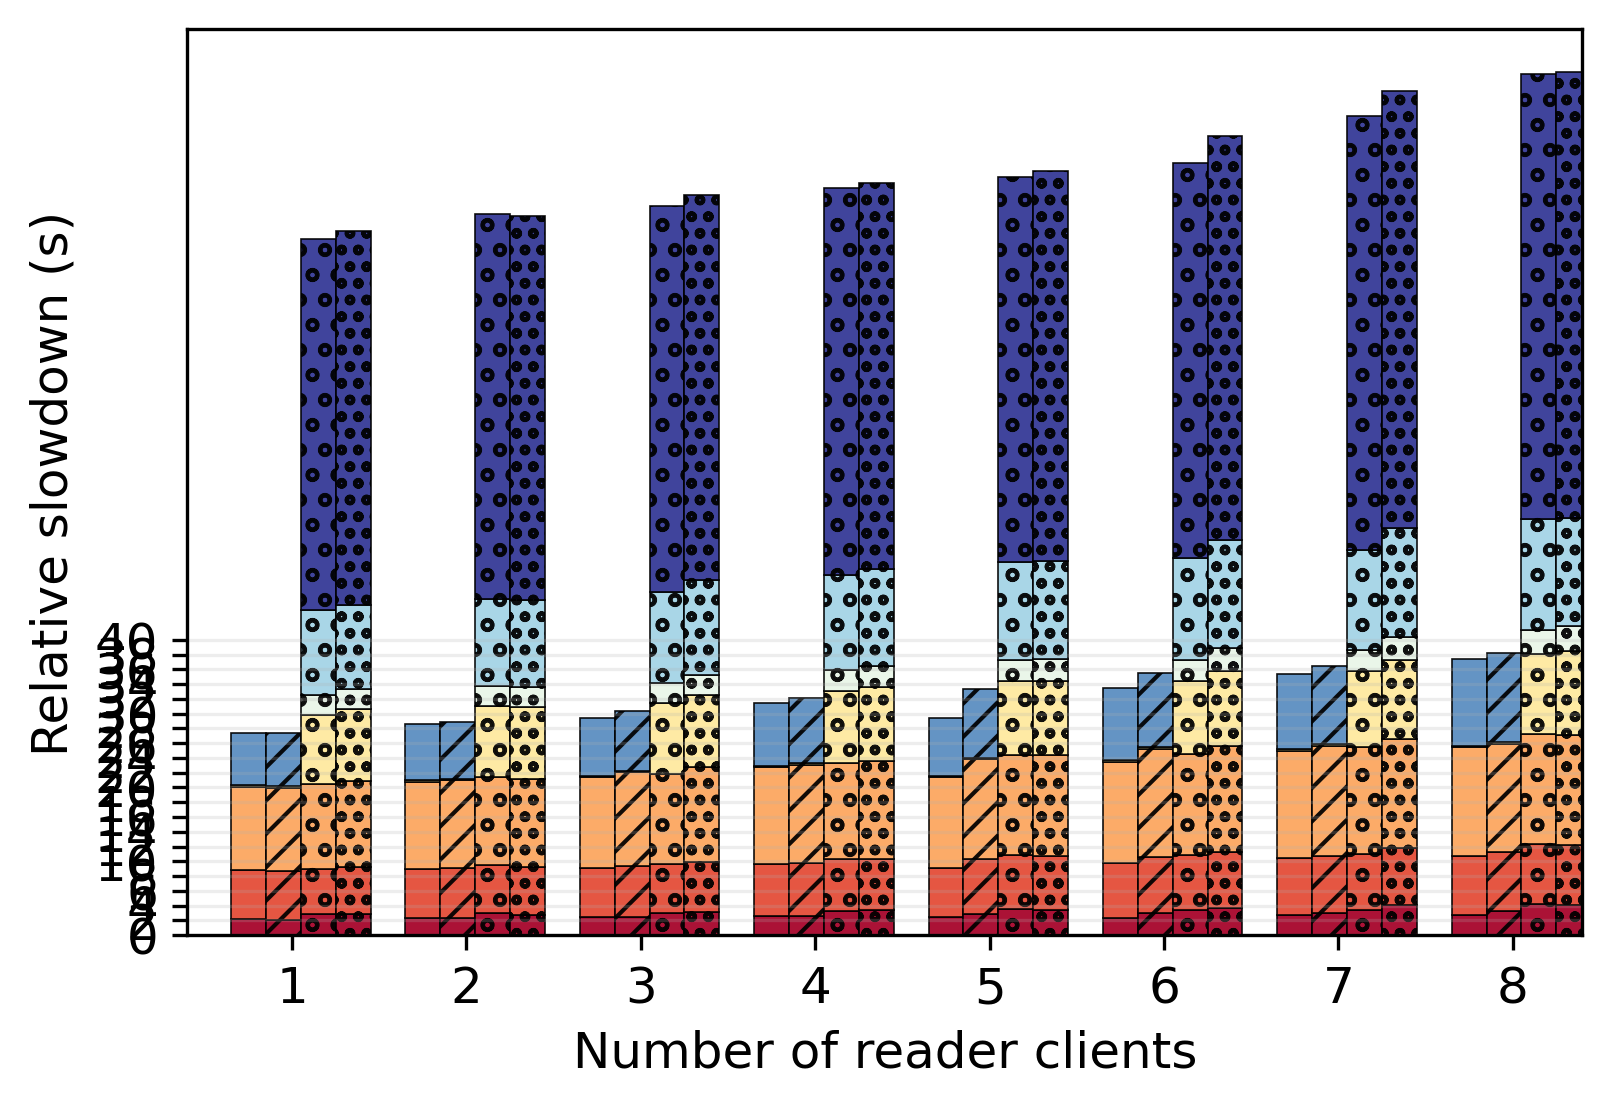

In [45]:
stacked_bar_runtime('interference/40/read_background',['1', '2', '3', '4', '5', '6', '7', '8'],['onepass_read_seq', 'onepass_read_rand', 'ems_read_seq', 'ems_read_rand'])

In [187]:
labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
op_pure = [2.00056,6.28685,11.2043,0.152445,0.0,0.0,6.56312,0.0]
# ems_pure = [2.40719,  6.05807, 11.3528, 9.00169, 2.63232, 11.3692 , 0.0, 12.1709]
ems_pure = [2.40719,  6.05807, 11.3528, 9.00169, 2.63232, 11.3692 , 0.0, 0.0]

def stacked_bar_read_overhead(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
                #tmp
                results.at[ix,'Total MERGE'] = 0
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            # print(df)
        send.append(df)
    # print(send)
    res = []
    for idf in send[:2]:
        res.append(idf.sub(op_pure, axis='columns'))
    for idf in send[2:]:
        res.append(idf.sub(ems_pure, axis='columns'))
    print(res)
    plot_clustered_stacked(res, exps, title="", cmap=plt.cm.RdYlBu)

[   RUN read  RUN sort RUN write RUN other  MERGE read  MERGE write  \
1   0.25455  0.256511  0.090732  0.038018         0.0          0.0   
2  0.366137  0.352897  0.545167  0.040612         0.0          0.0   
3  0.407781  0.373954   1.14181  0.043026         0.0          0.0   
4  0.628439   0.67306   1.93015  0.041254         0.0          0.0   
5  0.407781  0.373954   1.14181  0.043026         0.0          0.0   
6  0.312386   1.13816   2.54917  0.053182         0.0          0.0   
7  0.781738   1.42478   3.26908  0.063663         0.0          0.0   
8  0.751021   1.69531   3.52849  0.067745         0.0          0.0   

  RECORD read  MERGE other  
1    0.510075          0.0  
2     1.04704          0.0  
3     1.25364          0.0  
4     1.98428          0.0  
5     1.25364          0.0  
6     3.19957          0.0  
7     3.64961          0.0  
8       5.096          0.0  ,    RUN read  RUN sort RUN write RUN other  MERGE read  MERGE write  \
1   0.11466  0.286405  0.081641  0.0

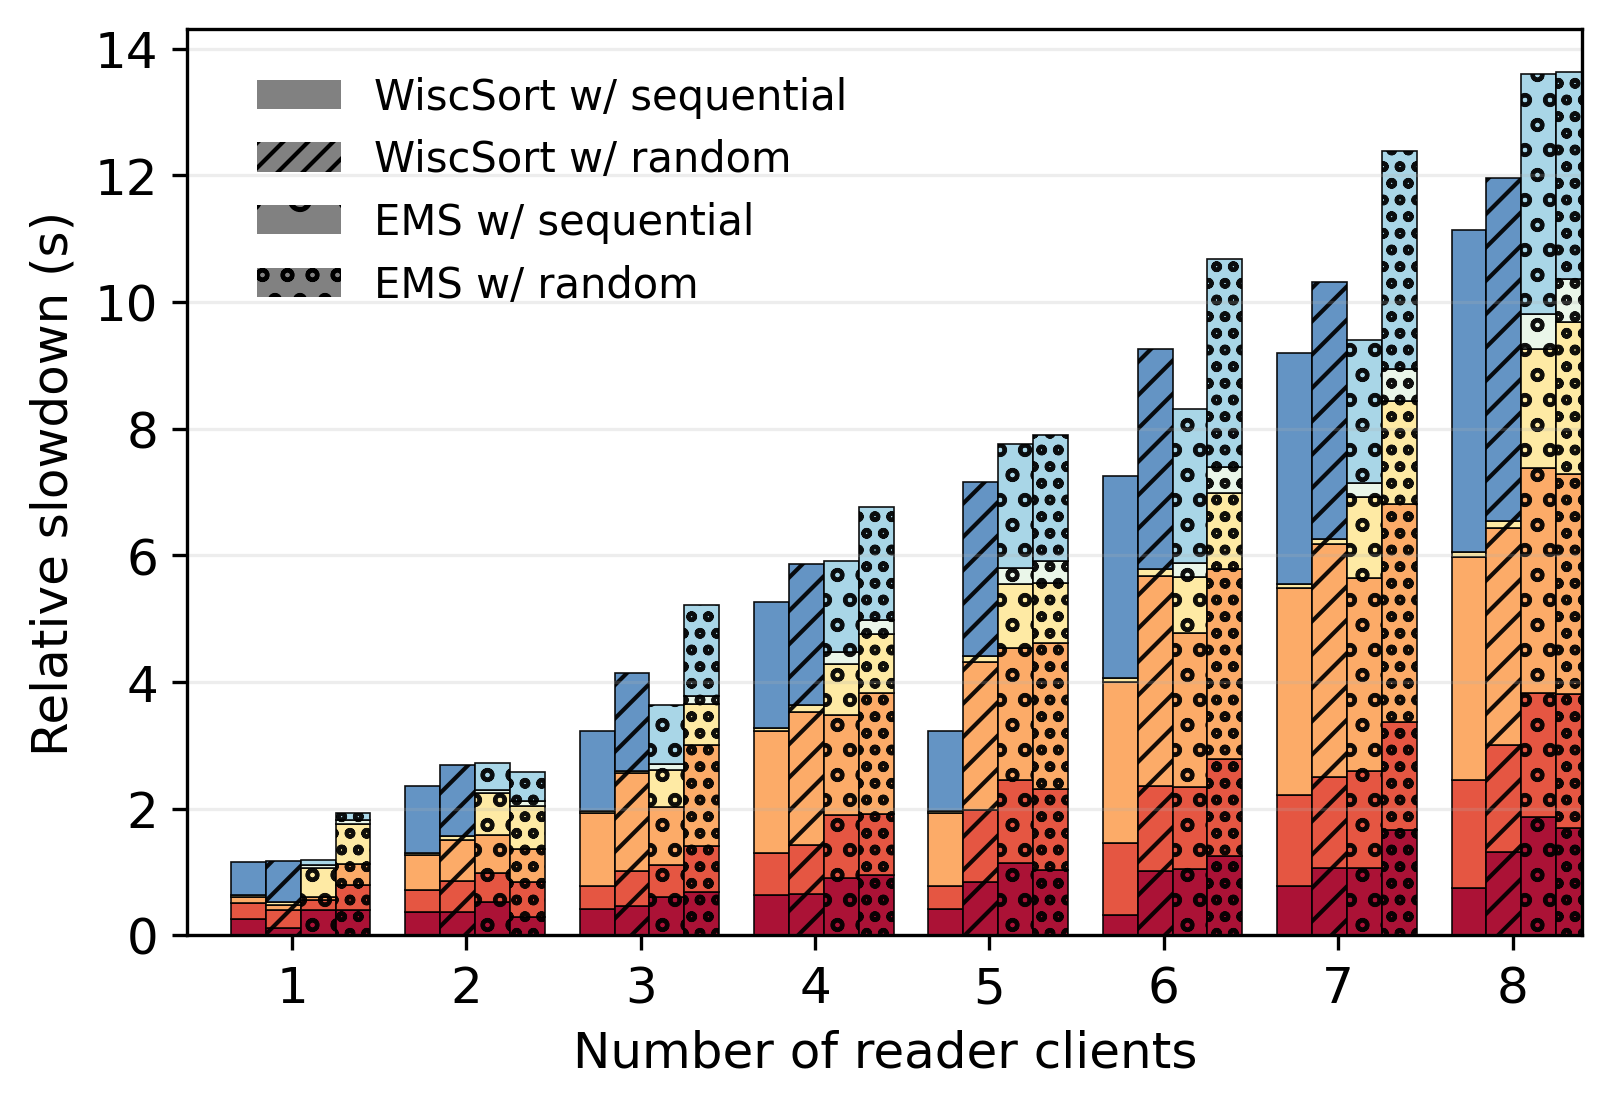

In [188]:
stacked_bar_read_overhead('interference/40/read_background',['1', '2', '3', '4', '5', '6', '7', '8'],['onepass_read_seq', 'onepass_read_rand', 'ems_read_seq', 'ems_read_rand'])

### Writer threads 

In [183]:
df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stackedl bar plot",  H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) new
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if i > 8:
                    rect.set_hatch("o" * int(i / n_col)) #edited part                         
                else:
                    rect.set_hatch("/" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 1000, 100))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Number of writer clients")
    # axe.set_ylabel("Relative slowdown (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    # l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(0.885,0.69),  prop={'size': 6})
    l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(0.33,0.85),  prop={'size': 10}, frameon = False, ncol=2)
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0, alpha=.99)) 
    n.append(axe.bar(0, 0, color="gray", hatch=H * 1, alpha=.99)) 
    
    labels = ['WiscSort', 'EMS']
    if labels is not None:
        # l2 = plt.legend(n, labels, loc=[1.01, 0.1])
        # l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.96,0.98), prop={'size': 6})
        l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.3,0.69), prop={'size': 10}, frameon = False)
    plt.savefig('interference-write-overhead.pdf', bbox_inches="tight")
    return axe
labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
op_pure = [2.00056,6.28685,11.2043,0.152445,0.0,0.0,6.56312,0.0]
# ems_pure = [2.40719,  6.05807, 11.3528, 9.00169, 2.63232, 11.3692 , 0.0, 12.1709]
ems_pure = [2.40719,  6.05807, 11.3528, 9.00169, 2.63232, 11.3692 , 0.0, 0.0]

def stacked_bar_read_overhead(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
                #tmp
                results.at[ix,'Total MERGE'] = 0
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            # print(df)
        send.append(df)
    # print(send)
    res = []
    for idf in send[:2]:
        res.append(idf.sub(op_pure, axis='columns'))
    for idf in send[2:]:
        res.append(idf.sub(ems_pure, axis='columns'))
    plot_clustered_stacked(res, exps, title="", cmap=plt.cm.RdYlBu)

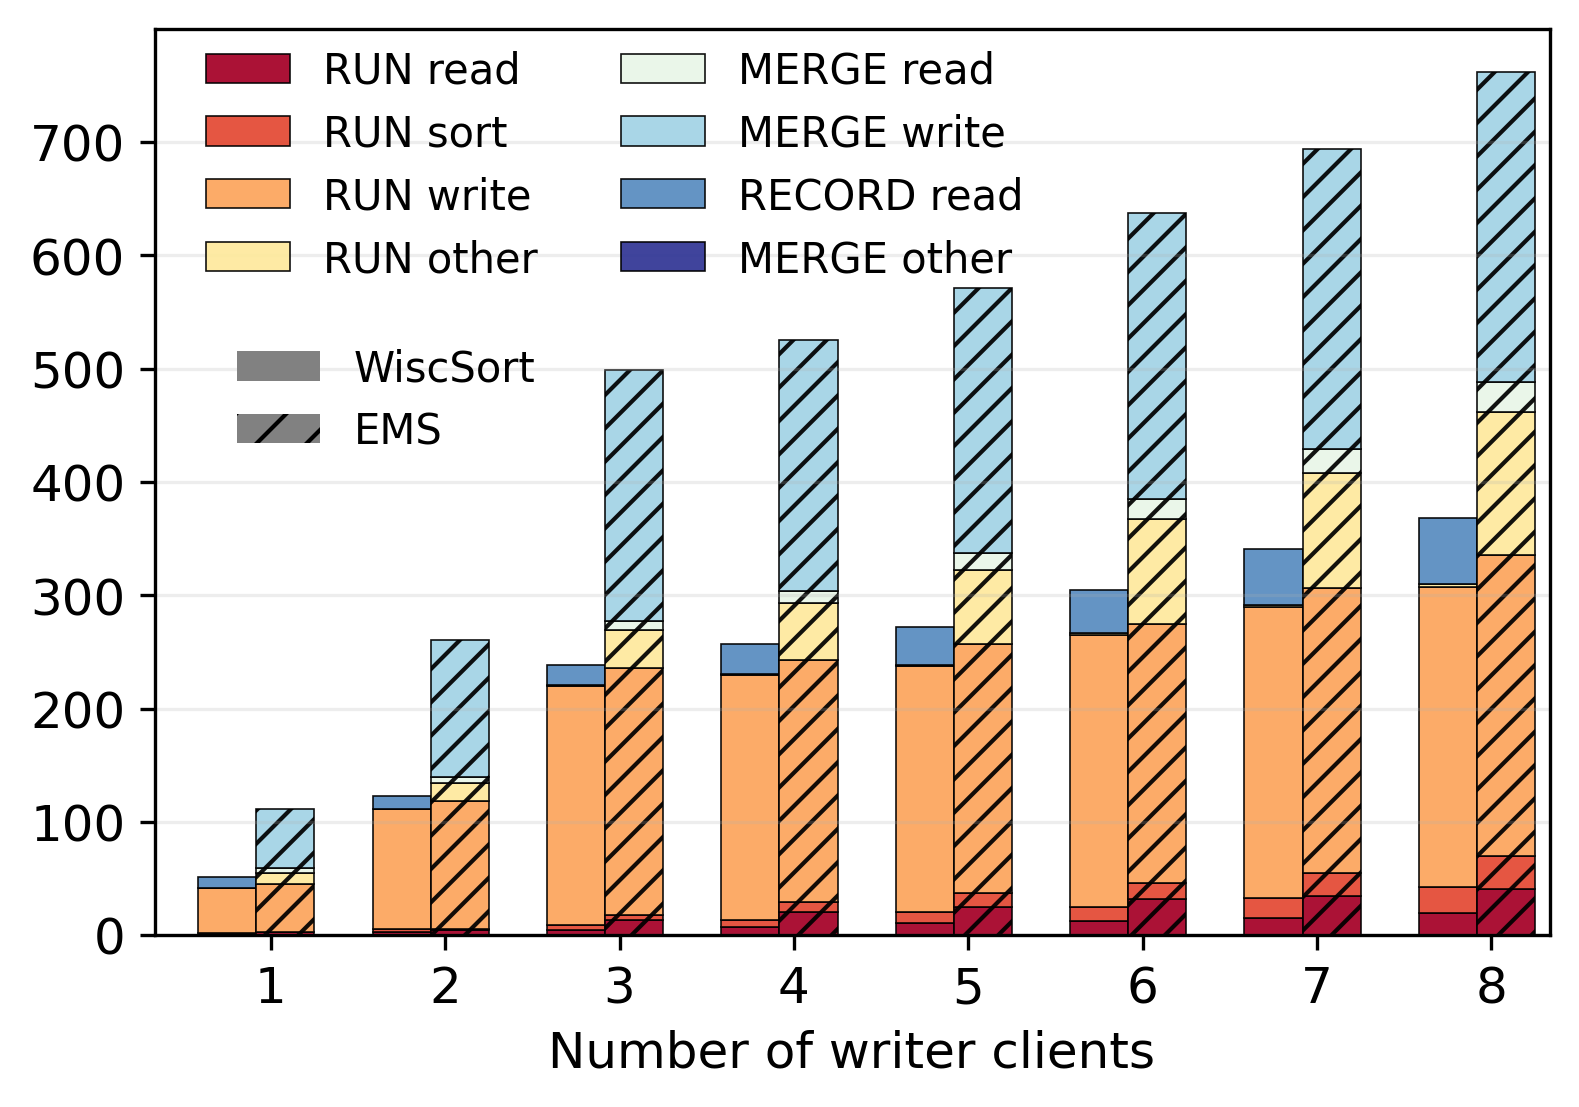

In [184]:
stacked_bar_read_overhead('interference/40/write_background',['1', '2', '3', '4', '5', '6', '7', '8'],['onepass_write', 'ems_write'])